In [15]:
#Section 1: Import Libraries and Load Data
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

#Ingested non-UTF8 CSV data using pandas, then performed analytical SQL queries using DuckDB.
df = pd.read_csv(
    "data.csv",
    encoding="latin1"
)

conn = duckdb.connect()

conn.register("retail", df)


In [16]:
#Section 2: Data Cleaning (SQL)
query_clean="""CREATE OR REPLACE TEMP VIEW retail_clean_data AS
SELECT *
FROM retail
WHERE Quantity > 0
  AND UnitPrice > 0
  AND CustomerID IS NOT NULL;"""
result = conn.execute(query_clean).df()

In [17]:
#Section 3: Total Revenue

query1="""SELECT
        ROUND(SUM(Quantity * UnitPrice), 2) AS total_revenue
    FROM retail_clean_data;
    """

revenue = conn.execute(query1).df()


print('TotalRevenuee:',f"{revenue.loc[0,'total_revenue']:,.2f}")

TotalRevenuee: 8,911,407.90


In [18]:
#Section 4: Monthly Revenue
query2="""SELECT
    strftime(strptime(InvoiceDate, '%m/%d/%Y %H:%M'), '%Y-%m') AS month,
    SUM(Quantity * UnitPrice) AS revenue
FROM retail_clean_data
GROUP BY month
ORDER BY month;
"""
monthly_df = conn.execute(query2).df()

monthly_df

,month,revenue
0,2010-12,572713.890
1,2011-01,569445.040
2,2011-02,447137.350
3,2011-03,595500.760
4,2011-04,469200.361
5,2011-05,678594.560
6,2011-06,661213.690
7,2011-07,600091.011
8,2011-08,645343.900
9,2011-09,952838.382


In [19]:
#Section 5: Top 10 Customers

query3="""SELECT
    CustomerID,
    SUM(Quantity * UnitPrice) AS revenue
FROM retail_clean_data
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
ORDER BY revenue DESC
LIMIT 10;
"""
top_customers_df = conn.execute(query3).df()
top_customers_df

,CustomerID,revenue
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06
5,12415.0,124914.53
6,14156.0,117379.63
7,17511.0,91062.38
8,16029.0,81024.84
9,12346.0,77183.60


In [20]:
#Section 6: Country-wise Revenue

query4="""SELECT
    Country,
    SUM(Quantity * UnitPrice) AS revenue
FROM retail_clean_data
--WHERE Country <> 'United Kingdom'
GROUP BY Country
ORDER BY revenue DESC
limit 5;"""

countries_df = conn.execute(query4).df()
countries_df

,Country,revenue
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050


In [21]:
query5="""SELECT
    Country,
    SUM(Quantity * UnitPrice) AS revenue
FROM retail_clean_data
WHERE Country <> 'United Kingdom'  --excluding UK
GROUP BY Country
ORDER BY revenue DESC
limit 5;"""

countries_df_UK = conn.execute(query5).df()
countries_df_UK

,Country,revenue
0,Netherlands,285446.34
1,EIRE,265545.90
2,Germany,228867.14
3,France,209024.05
4,Australia,138521.31


In [22]:
#Section7: Returned Customers
query6="""SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS orders_count
FROM retail_clean_data
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
HAVING orders_count > 1
ORDER BY orders_count DESC
limit 10;
"""

repeat_customers_df = conn.execute(query6).df()
repeat_customers_df

,CustomerID,orders_count
0,12748.0,209
1,14911.0,201
2,17841.0,124
3,13089.0,97
4,14606.0,93
5,15311.0,91
6,12971.0,86
7,14646.0,73
8,16029.0,63
9,13408.0,62


In [23]:
#Section 8: Customer Ranking 
query7="""
SELECT
    CustomerID,
    SUM(Quantity * UnitPrice) AS revenue,
    RANK() OVER (ORDER BY SUM(Quantity * UnitPrice) DESC) AS rank
FROM retail_clean_data
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
order by rank
limit 10;"""

ranked_customers_df = conn.execute(query7).df()
ranked_customers_df

,CustomerID,revenue,rank
0,14646.0,280206.02,1
1,18102.0,259657.30,2
2,17450.0,194550.79,3
3,16446.0,168472.50,4
4,14911.0,143825.06,5
5,12415.0,124914.53,6
6,14156.0,117379.63,7
7,17511.0,91062.38,8
8,16029.0,81024.84,9
9,12346.0,77183.60,10


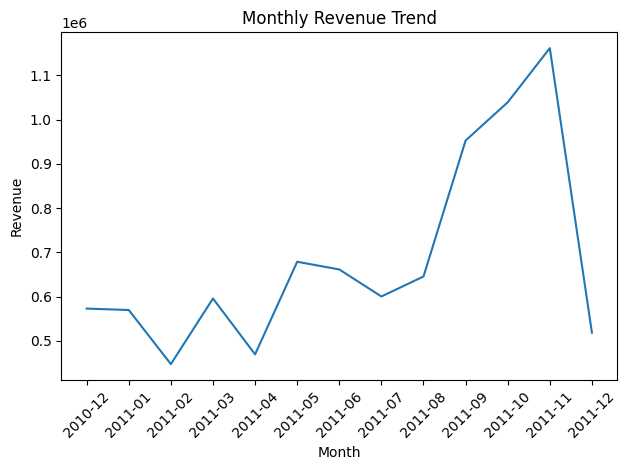

In [24]:
#Visualization
#Chart 1: Monthly Revenue Trend
plt.figure()
plt.plot(monthly_df['month'], monthly_df['revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

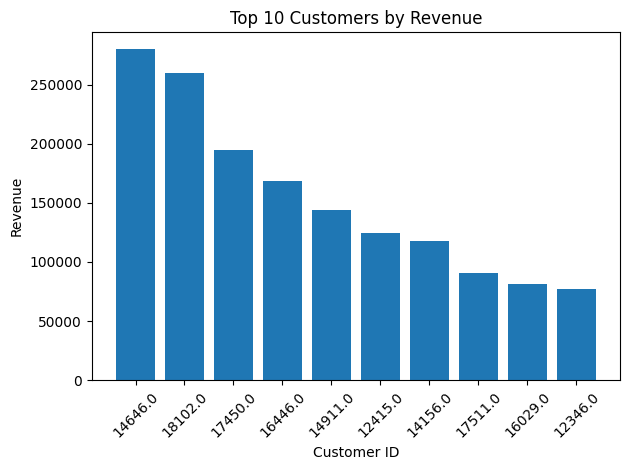

In [25]:
#Chart 2: Top 10 Customers
plt.figure()
plt.bar(top_customers_df['CustomerID'].astype(str), top_customers_df['revenue'])
plt.xticks(rotation=45)
plt.title('Top 10 Customers by Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


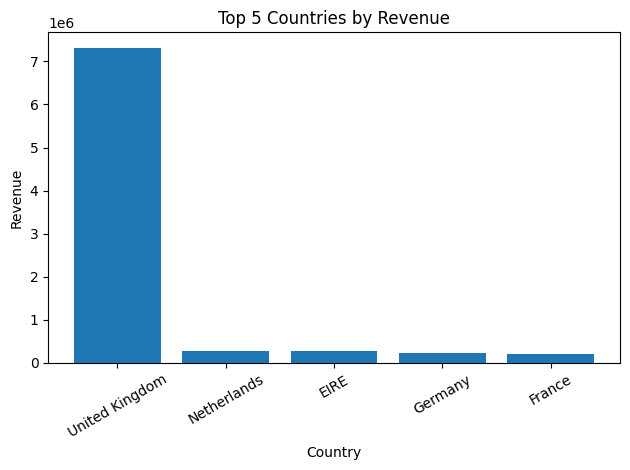

In [26]:
##Chart 3: Top 5 Countries

plt.figure()
plt.bar(countries_df['Country'], countries_df['revenue'])
plt.xticks(rotation=30)
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


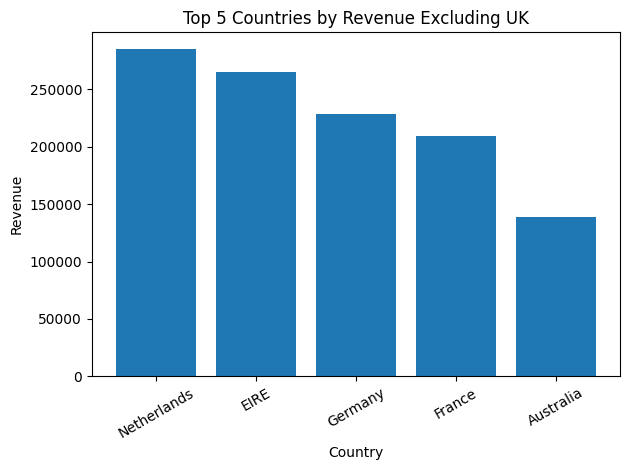

In [27]:
##Chart 4: Top 5 Countries Excluding UK

plt.figure()
plt.bar(countries_df_UK['Country'], countries_df_UK['revenue'])
plt.xticks(rotation=30)
plt.title('Top 5 Countries by Revenue Excluding UK')
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

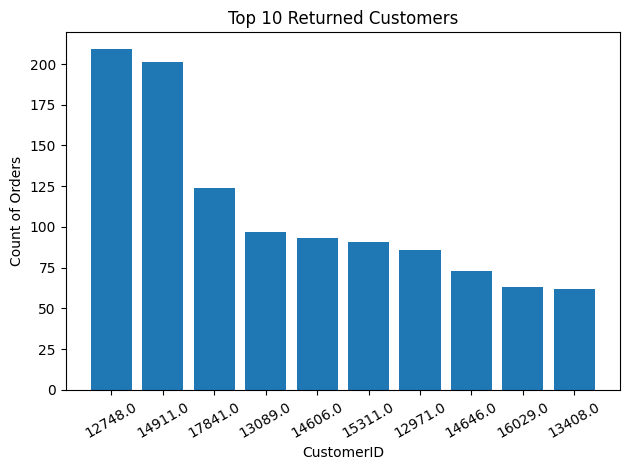

In [29]:
#Chart 5: Returned_Customers
plt.figure()
plt.bar(repeat_customers_df['CustomerID'].astype(str), repeat_customers_df['orders_count'])
plt.xticks(rotation=30)
plt.title('Top 10 Returned Customers')
plt.xlabel('CustomerID')
plt.ylabel('Count of Orders')
plt.tight_layout()
plt.show()
